In [23]:
import pandas as pd
import altair as alt
import numpy as np
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')
# Gradescope only supports displaying plots as images
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [29]:
# Load data
df = pd.read_csv('abalone.data', names = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings'])

# Add a classification target columns. If rings > 10, then classified as old
df['is_old'] = np.where(df['rings'] > 10, 1, 0)
df

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,is_old
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0
...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,1
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,0


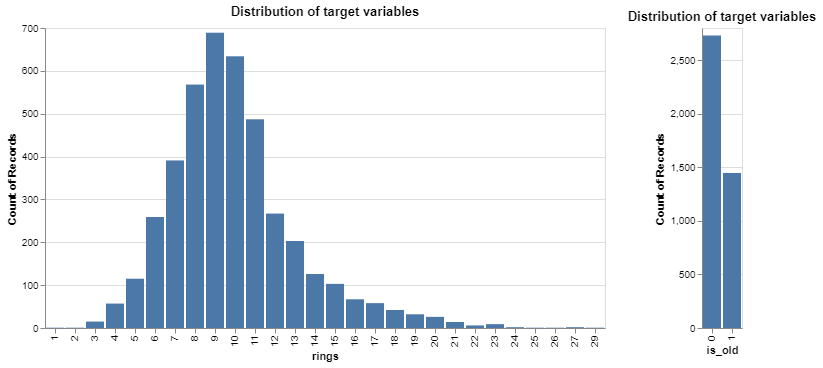

In [34]:
# Distribution of our target: rings and is_old
alt.Chart(df, title = 'Distribution of target variables').mark_bar().encode(
    alt.X(alt.repeat(), type='nominal'),
    alt.Y('count()')
).repeat(
    ['rings', 'is_old']
)

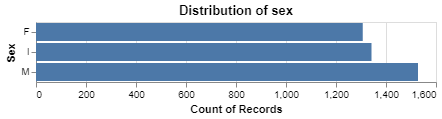

In [22]:
# Distribution of categorical variable: sex
alt.Chart(df, title = 'Distribution of sex').mark_bar().encode(
    alt.Y('sex', title = 'Sex'),
    alt.X('count()')
)

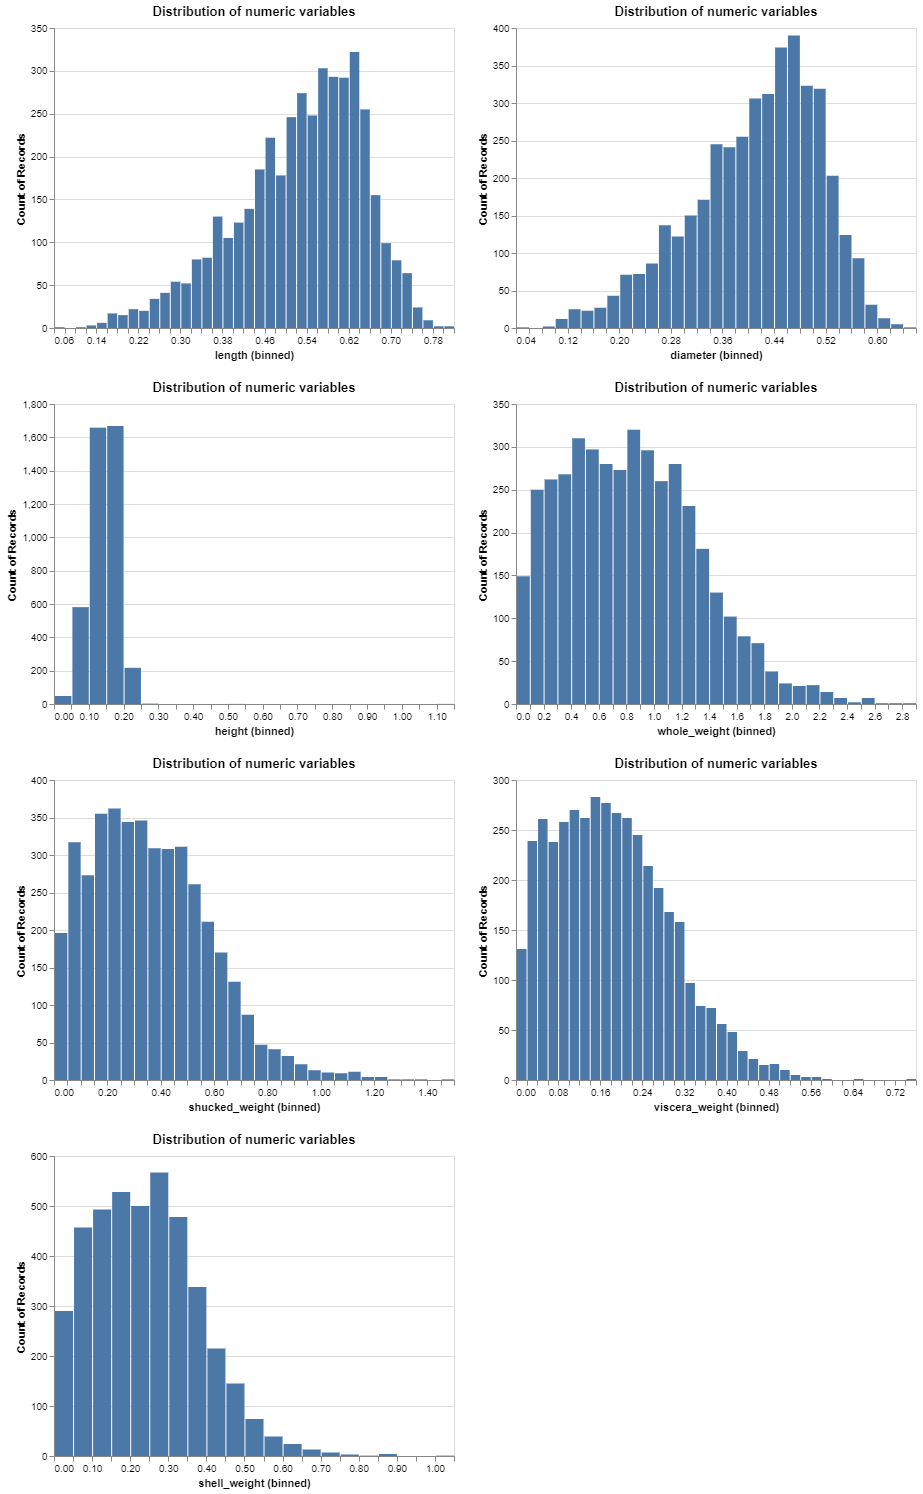

In [45]:
# Distribution of numeric variables: 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'
alt.Chart(df, title = 'Distribution of numeric variables').mark_bar().encode(
    alt.X(alt.repeat(), type='quantitative', bin = alt.Bin(maxbins = 50)),
    alt.Y('count()')
).repeat(
    ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'],
    columns = 2
)